# Chapter 7: Ulysses' Compass - Samples


> <span style="color:blue">OCKHAM'S RAZOR</span>. *Models with fewer assumptions are to be preferred.*

We can look into two fundamental kinds of statistical errors:

1. Overfitting: High variance.
2. Underfitting: High bias.

There are two ways to deal with this, we can use a <span style="color:blue">REGULARIZING PRIOR</span> to calm the model down. We can also use the <span style="color:blue">INFORMATION CRITERIA</span> or the <span style="color:blue">CROSS-VALIDATION</span>.

Before **information criteria**, we will need first to define <span style="color:blue">INFORMATION THEORY</span>. 

We start using **information criteria** with **AIC**, **DIC**, **WAIC** and **PSIS**.

## 7.1 The problem with parameters.

If we add too many parameters, it will improve fitting, but it will predict new data worse.

### 7.1.1. More parameters (almost) always improve fit.

We can look into one example.

#### Code 7.1.

In [1]:
import pandas as pd

d = pd.DataFrame(
    {
        'species': [
            'afarensis',
            'africanus',
            'habilis',
            'boisei',
            'rudolfensis',
            'ergaster',
            'sapiens',
        ],
        'brain': [438, 452, 612, 521, 752, 871, 1350],  # volume in cc
        'mass': [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5],  # mass in kg
    }
)

d.head()

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5


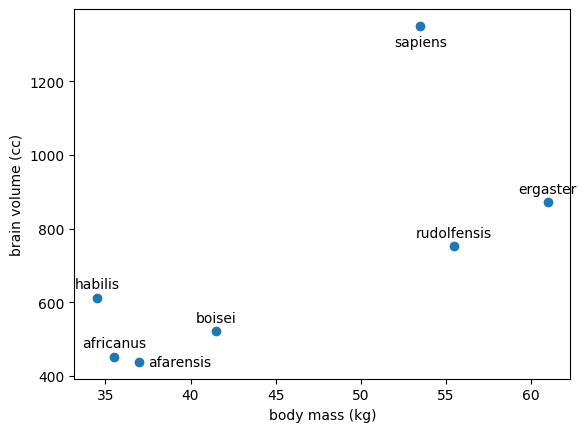

In [2]:
from matplotlib import pyplot as plt


# Figure 7.2
plt.scatter(d['mass'], d['brain'])

# point labels
for i, r in d.iterrows():
    if r.species == 'afarensis':
        plt.text(r.mass + 0.5, r.brain, r.species, ha='left', va='center')
    elif r.species == 'sapiens':
        plt.text(r.mass, r.brain - 25, r.species, ha='center', va='top')
    else:
        plt.text(r.mass, r.brain + 25, r.species, ha='center')

plt.xlabel('body mass (kg)')
plt.ylabel('brain volume (cc)');

The simplest model that fits body with brain size is a linear model. We start by standardizing the variables.

#### Code 7.2.

In [3]:
from rethinking import standardize

mass_std = standardize(d['mass']).values
brain_std = (d['brain'] / d['brain'].max()).values

Here is the mathematical version of the first linear model.

$$
\begin{aligned}
b_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta m_i \\
\alpha &\sim \text{Normal}(0.5, 1) \\
\beta &\sim \text{Normal}(0, 10) \\
\sigma &\sim \text{Log-Normal}(0, 1) \\
\end{aligned}
$$

Let's continue to fit the model now

#### Code 7.3

In [4]:
import pymc as pm
import numpy as np
from rethinking import quap, precis


with pm.Model() as model:
    sigma = pm.Normal('sigma', 0, 1)
    b = pm.Normal('b', 0, 10)
    a = pm.Normal('a', 0.5, 1)
    mu = pm.Deterministic('mu', a + b * mass_std)
    brain = pm.Normal('brain', mu, np.exp(sigma), observed=brain_std)
    
    post, vars_ = quap(model)

var_names = [v.name for v in vars_]
precis(post, var_names)

,mean,std,5.5%,94.5%
sigma,-1.708103,0.294959,-2.173266,-1.234499
b,0.167081,0.073391,0.048806,0.285621
a,0.527737,0.068235,0.419553,0.636587


It is also possible to use OLS to get posterior distributions for these brain size models.

#### Code 7.4

In [5]:
import statsmodels.formula.api as smf

d['mass_std'] = mass_std
d['brain_std'] = brain_std

m_7_1_ols = smf.ols('brain_std ~ mass_std', data=d).fit()
m_7_1_ols.summary()

/Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              brain_std   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     4.807
Date:                Sat, 08 Oct 2022   Prob (F-statistic):             0.0798
Time:                        11:02:15   Log-Likelihood:                 2.9925
No. Observations:                   7   AIC:                            -1.985
Df Residuals:                       5   BIC:                            -2.093
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5287      0.071      7.492      0.001       0.347       0.710
mass_std       0.1671      0.076      2.192      0.080      -0.029       0.363
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.561
Prob(Omnibus):                    nan   Jarque-Bera (JB):                2.372
Skew:                           1.399   Prob(JB):                        0.305
Kurtosis:                       3.548   Cond. No.                         1.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can code $R^2$ to check the variance explained by the model.

#### Code 7.5

In [6]:
n_simulations = len(d)
post_data = pd.DataFrame(post.rvs(10_000), columns=var_names)

mus = post_data[['a']].to_numpy() + post_data[['b']].to_numpy() * np.tile(mass_std, (10_000, 1))
sigmas = np.tile(np.exp(post_data['sigma']), (n_simulations, 1)).T

# Simulation
s = np.random.normal(
    size=(10_000, n_simulations),
    loc=mus,
    scale=sigmas
)

r = s.mean(axis=0) - brain_std
resid_var = np.var(r)
outcome_var = np.var(brain_std)
1 - resid_var / outcome_var

0.49831114036660484

Since we will want to do this for several functions, let's write a function.

#### Code 7.6

In [7]:
def r2_is_bad(simulation, real):
    r = simulation.mean(axis=0) - real
    resid_var = np.var(r)
    outcome_var = np.var(real)
    return 1 - resid_var / outcome_var

Use a polynomial.

#### Code 7.7

In [8]:
with pm.Model() as model:
    sigma = pm.Normal('sigma', 0, 1)
    b = pm.Normal('b', 0, 10, shape=2)
    a = pm.Normal('a', 0.5, 1)
    mu = pm.Deterministic('mu', a + b[0] * mass_std + b[1] * mass_std**2)
    brain = pm.Normal('brain', mu, np.exp(sigma), observed=brain_std)
    
    post2, vars_ = quap(model)

var_names = ['sigma', 'b1', 'b2', 'a']
precis(post2, var_names)

,mean,std,5.5%,94.5%
sigma,-1.749197,0.291857,-2.217981,-1.283123
b1,0.194599,0.082324,0.063693,0.325980
b2,-0.096031,0.137351,-0.315270,0.122033
a,0.610283,0.134482,0.391387,0.822008


The next models are constructed in a similar fashion.

#### Code 7.8 & 7.9

In [9]:
with pm.Model() as model:
    sigma = pm.Normal('sigma', 0, 1)
    b = pm.Normal('b', 0, 10, shape=3)
    a = pm.Normal('a', 0.5, 1)
    mu = pm.Deterministic(
        'mu', 
        a 
        + b[0] * mass_std 
        + b[1] * mass_std**2
        + b[2] * mass_std**3
    )
    brain = pm.Normal('brain', mu, np.exp(sigma), observed=brain_std)
    
    post3, vars_ = quap(model)

with pm.Model() as model:
    sigma = pm.Normal('sigma', 0, 1)
    b = pm.Normal('b', 0, 10, shape=4)
    a = pm.Normal('a', 0.5, 1)
    mu = pm.Deterministic(
        'mu', 
        a 
        + b[0] * mass_std 
        + b[1] * mass_std**2
        + b[2] * mass_std**3
        + b[3] * mass_std**4
    )
    brain = pm.Normal('brain', mu, np.exp(sigma), observed=brain_std)
    
    post4, vars_ = quap(model)
    
with pm.Model() as model:
    sigma = pm.Normal('sigma', 0, 1)
    b = pm.Normal('b', 0, 10, shape=5)
    a = pm.Normal('a', 0.5, 1)
    mu = pm.Deterministic(
        'mu', 
        a 
        + b[0] * mass_std 
        + b[1] * mass_std**2
        + b[2] * mass_std**3
        + b[3] * mass_std**4
        + b[4] * mass_std**5
    )
    brain = pm.Normal('brain', mu, np.exp(sigma), observed=brain_std)
    
    post5, vars_ = quap(model)
    
with pm.Model() as model:
    b = pm.Normal('b', 0, 10, shape=6)
    a = pm.Normal('a', 0.5, 1)
    mu = pm.Deterministic(
        'mu', 
        a 
        + b[0] * mass_std 
        + b[1] * mass_std**2
        + b[2] * mass_std**3
        + b[3] * mass_std**4
        + b[4] * mass_std**5
        + b[5] * mass_std**6
    )
    brain = pm.Normal('brain', mu, 0.001, observed=brain_std)
    
    post6, vars_ = quap(model)

Now we can plot everything.

#### Code 7.10

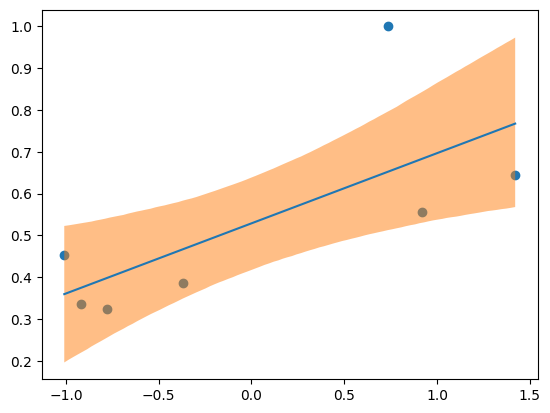

In [10]:
def link(posterior, seq):
    post = posterior.rvs(size=10_000)
    weights_seq = np.tile(seq, (10_000, 1))
    mu = post[:, 0:1] + post[:, 1:2] * (weights_seq - d2['weight'].mean())
    return mu

post_data = post_data = pd.DataFrame(post.rvs(10_000), columns=['sigma', 'b1', 'a'])
mass_seq = np.linspace(mass_std.min(), mass_std.max(), 100)
mass = np.tile(mass_seq, (10_000, 1))
l = post_data[['a']].values + post_data[['b1']].values * mass
mu = l.mean(axis=0)
ci = np.array([np.quantile(val, [0.055, 0.945]) for val in l.T])

plt.scatter(mass_std, brain_std);
plt.plot(mass_seq, mu)
plt.fill_between(mass_seq, ci[:, 0], ci[:,1], alpha=0.5);

### 7.1.2 Too few parameters hurts, too

Overfit polynomial models fit the data really well, but they suffer from within-sample accuracy. 

We can remove rows using code.

#### Code 7.11

In [11]:
brains_new = d.drop(d.index[-1])

## 7.2 Entropy and Accuracy

In defining a target there are two major dimensions to worry about:

### 7.2.1 Firing the weatherperson

1. *Cost-benefit analysis*. Measure how much it costs when we are wrong.
2. *Accuracy in context*. We still need to judge accuracy.

### 7.2.1.1. *Cost and Benefits*

### 7.2.1.2. *Measuring accuracy*

### 7.2.2 Information and Uncertainty

To calculate the information entropy for the weather, suppose the true probabilities of rain and shine are $p_1 = 0.3$ and $p_2 = 0.7$.

$$H(p) = -(p_1\text{log}(p_1) + p_2\text{log}(p_2)) \approx 0.61$$

In [12]:
p = np.array([0.3, 0.7])
-sum(p * np.log(p))

0.6108643020548935

### 7.2.3 From entropy to accuracy

We need a way to quantify uncertainty. $H$ provides this.

How can we use information entropy to say how far a model is from the target? The key lies in <span style="color:blue">DIVERGENCE</span>:

> **Divergence**: The additional uncertainty induced by using probabilities from one distribution to describe another distribution.

This is often called *Kullback-Leibler divergence*.

$$D_{KL}(p, q) = \sum_ip_i(\text{log}(p_1) - log(q_i)) = \sum_ip_i\text{log}\left(\frac{p_i}{q_i}\right)$$

### 7.2.4 Estimating Divergence

We don't need to know the real probability, we only need to know how closer we are to the real probability.

$$S(q) = \sum_i\text{log}(q_i)$$

We need to find the log of the average probability for each observation $i$, where the average is taken over the posterior distribution.

The Bayesian version of the log-probability score is called the <span style="color:blue">LOG-POINTWISE-PREDICTIVE-DENSITY</span>

$$\text{lppd}(y, \Theta) = \sum_i\text{log}\frac{1}{S}\sum_sp(y_i, \Theta_s)$$

#### Code 7.13 & 7.14

In [13]:
from scipy import stats
from scipy.special import logsumexp

post_data = pd.DataFrame(post.rvs(10_000), columns=['sigma', 'b', 'a'])
mu = (post_data[['a']].values + post_data[['b']].values * mass_std).T
sig = np.exp(post_data[['sigma']].values).T

# Log prob is prefered so we don't have rounding problems after.
logprob = stats.norm.logpdf(
    brain_std.reshape(-1, 1),
    loc=mu,
    scale=sig
)
logsumexp(logprob, axis=1) - np.log(logprob.shape[1])

array([ 0.61588341,  0.65392162,  0.54624486,  0.62894367,  0.46756664,
        0.43438907, -0.8429347 ])

### 7.2.5 Scoring the right data.

We could then do the same for the rest of the models.

#### Code 7.15

In [14]:
def lppd(mu, sigma):
    logprob = stats.norm.logpdf(
        brain_std.reshape(-1, 1),
        loc=mu,
        scale=sigma
    )
    return logsumexp(logprob, axis=1) - np.log(logprob.shape[1])

# 7.2
post_data2 = pd.DataFrame(post2.rvs(10_000), columns=['sigma', 'b1', 'b2', 'a'])
mu2 = (
    post_data2[['a']].values 
    + post_data2[['b1']].values * mass_std
    + post_data2[['b2']].values * mass_std**2
).T
sig2 = np.exp(post_data2[['sigma']].values).T

# 7.3
post_data3 = pd.DataFrame(post3.rvs(10_000), columns=['sigma', 'b1', 'b2', 'b3', 'a'])
mu3 = (
    post_data3[['a']].values 
    + post_data3[['b1']].values * mass_std
    + post_data3[['b2']].values * mass_std**2
    + post_data3[['b3']].values * mass_std**3
).T
sig3 = np.exp(post_data3[['sigma']].values).T

# 7.4
post_data4 = pd.DataFrame(post4.rvs(10_000), columns=['sigma', 'b1', 'b2', 'b3', 'b4', 'a'])
mu4 = (
    post_data4[['a']].values 
    + post_data4[['b1']].values * mass_std
    + post_data4[['b2']].values * mass_std**2
    + post_data4[['b3']].values * mass_std**3
    + post_data4[['b4']].values * mass_std**3
).T
sig4 = np.exp(post_data4[['sigma']].values).T

# 7.5
# 7.6

for mu_, sigma_ in zip([mu, mu2, mu3, mu4], [sig, sig2, sig3, sig4]):
    print(sum(lppd(mu_, sigma_)))

2.5040145729735297
2.6023066475836867
3.717550263252461
-5.36349552171207


Simulating training and testing.

#### Code 7.16

In [15]:
import arviz as az

def sim_train_test(N=20, k=3, rho=[0.15, -0.4], b_sigma=100, samples=1000):

    n_dim = 1 + len(rho)
    if n_dim < k:
        n_dim = k
    Rho = np.diag(np.ones(n_dim))
    Rho[0, 1:3:1] = rho
    i_lower = np.tril_indices(n_dim, -1)
    Rho[i_lower] = Rho.T[i_lower]

    x_train = stats.multivariate_normal.rvs(cov=Rho, size=N)
    x_test = stats.multivariate_normal.rvs(cov=Rho, size=N)

    mm_train = np.ones((N, 1))
    np.concatenate([mm_train, x_train[:, 1:k]], axis=1)

    # Using pymc
    with pm.Model() as m_sim:
        vec_V = pm.MvNormal(
            'vec_V',
            mu=0,
            cov=b_sigma * np.eye(n_dim),
            shape=(1, n_dim),
            initval=np.random.randn(1, n_dim) * 0.01,
        )
        mu = pm.Deterministic('mu', 0 + pm.math.dot(x_train, vec_V.T))
        y = pm.Normal('y', mu=mu, sigma=1, observed=x_train[:, 0].reshape(-1, 1))

    with m_sim:
        trace_m_sim = pm.sample(samples, progressbar=False)

    vec = az.summary(trace_m_sim)['mean'][:n_dim]
    vec = np.array([i for i in vec]).reshape(n_dim, -1)
    dev_train = -2 * sum(stats.norm.logpdf(x_train, loc=np.matmul(x_train, vec), scale=1))
    mm_test = np.ones((N, 1))
    mm_test = np.concatenate([mm_test, x_test[:, 1 : k + 1]], axis=1)
    dev_test = -2 * sum(stats.norm.logpdf(x_test[:, 0], loc=np.matmul(mm_test, vec), scale=1))
    return np.mean(dev_train), np.mean(dev_test)

# This cell is expected have a long run time
n = 20
tries = 4
num_param = np.arange(2, 7)
r = np.zeros(shape=(len(num_param), 4))

for k in num_param:
    print(f'Num Params: {k}')
    
    train = []
    test = []
    for _ in range(tries):
        tr, te = sim_train_test(N=n, k=k, samples=1000)
        print(f'Results: {tr}, {te}')
        train.append(tr), test.append(te)
        
    r[k - 2, :] = (
        np.mean(train),
        np.std(train, ddof=1),
        np.mean(test),
        np.std(test, ddof=1),
    )                           

Num Params: 2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


Results: 59.51563400848173, 78.17471294872331


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


Results: 75.11708285057902, 68.74023245876229


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Results: 73.48009135174787, 81.22124380982854


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Results: 58.0604332159555, 83.31769785143584
Num Params: 3


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


Results: 58.47084066116705, 83.17407465753142


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Results: 78.80300716997264, 66.43844508025407


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Results: 72.8078962909426, 78.93795604727994


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


Results: 63.909639099643265, 85.59575082664601
Num Params: 4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


Results: 61.43419046992234, 61.35581046243776


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Results: 82.7697238178778, 70.97116360054838


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Results: 80.73280578121017, 86.33271419608754


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Results: 78.81513203410002, 56.34003547475059
Num Params: 5


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Results: 76.90880726677918, 56.43884597794543


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Results: 71.07221767367777, 75.09686288630465


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


Results: 69.19831989422872, 74.7423245148388


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Results: 67.04809830073341, 60.922843691590955
Num Params: 6


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


Results: 75.74237763532733, 67.21247465223082


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Results: 61.20548706527978, 60.15235195908864


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


Results: 64.53314947896001, 68.53745048778521


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


Results: 73.65042145763461, 72.28368361561104


#### Code 7.18

Let's plot.

([<matplotlib.axis.XTick at 0x175fb3d00>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

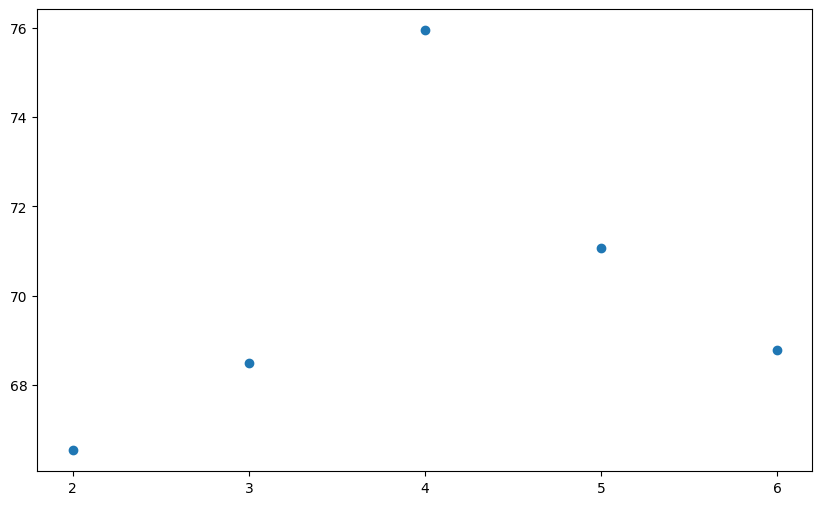

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(num_param, r[:, 0], color="C0")
plt.xticks(num_param)

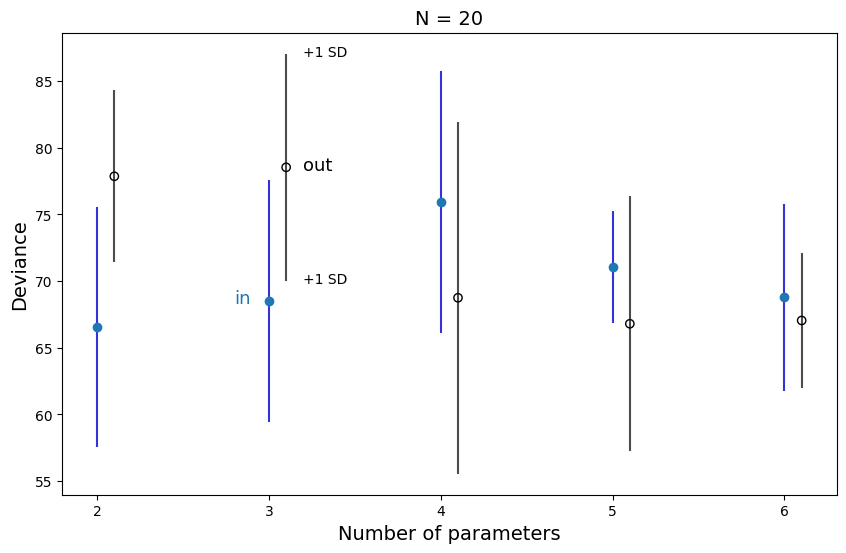

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(num_param, r[:, 0], color="C0")
plt.xticks(num_param)

for j in range(len(num_param)):
    plt.vlines(
        num_param[j],
        r[j, 0] - r[j, 1],
        r[j, 0] + r[j, 1],
        color="mediumblue",
        zorder=-1,
        alpha=0.80,
    )

plt.scatter(num_param + 0.1, r[:, 2], facecolors="none", edgecolors="k")

for j in range(len(num_param)):
    plt.vlines(
        num_param[j] + 0.1,
        r[j, 2] - r[j, 3],
        r[j, 2] + r[j, 3],
        color="k",
        zorder=-2,
        alpha=0.70,
    )

dist = 0.20
plt.text(num_param[1] - dist, r[1, 0] - dist, "in", color="C0", fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] - dist, "out", color="k", fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] + r[1, 3] - dist, "+1 SD", color="k", fontsize=10)
plt.text(num_param[1] + dist, r[1, 2] - r[1, 3] - dist, "+1 SD", color="k", fontsize=10)
plt.xlabel("Number of parameters", fontsize=14)
plt.ylabel("Deviance", fontsize=14)
plt.title(f"N = {n}", fontsize=14)
plt.show()

Both *Cross Validation* and *Information Criteria* produce very similar results.

### 7.4.1 Cross-Validaiton

A very common one to use: <span style="color:blue">LEAVE-ONE-OUT-CV</span> or LOOCV.

<span style="color:blue">PSIS</span>: Is an approximation of the CV Score by using weights. It also uses the Paretto's distribution to smooth the weights.

$$s_{\text{PSIS}} = \sqrt{N\text{var}(\text{psis}_i)}$$

### 7.4.2 Information criteria

<span style="color:blue">AIC</span>: Historical information criterion, that uses the number of parameters to show the potential divergence of a model.

$$\text{AIC} = D_{\text{train}} + 2p = -2\text{lppd} + 2p$$

<span style="color:blue">DIC</span>: Better with informative priors, but assumes multivariate Normal distribution and N to be much bigger than k.

<span style="color:blue">WAIC</span>: More general than AIC and DIC, makes no assumption of the shape of the posterior.

$$\text{WAIC}(y,\Theta) == -2(\text{lppd} - \sum_i \text{var}_\theta \text{log} p(y_i, \theta))$$

Let's go throught he calculations.

#### Code 7.19 - 7.24

In [18]:
from rethinking import DATA_PATH

cars = pd.read_csv(DATA_PATH.joinpath('cars.csv'), usecols=[1,2])
speed = cars['speed'].values
dist_o = cars['dist'].values

with pm.Model() as model:
    sigma = pm.Exponential('sigma', 1)
    b = pm.Normal('b', 0, 10)
    a = pm.Normal('a', 0, 100)
    mu = pm.Deterministic('mu', a + b * speed)
    dist = pm.Normal('dist', mu, sigma, observed=dist_o)
    
    post, vars_ = quap(model)

var_names = [var.name for var in vars_]
precis(post, var_names)

,mean,std,5.5%,94.5%
sigma,13.384978,0.084714,13.248861,13.519775
b,3.923574,0.358522,3.346917,4.501348
a,-17.443729,5.816274,-26.736764,-8.142407


In [19]:
post_data = pd.DataFrame(post.rvs(10_000), columns=['sigma', 'b', 'a'])
mu = (post_data[['a']].values + post_data[['b']].values * speed).T
sig = post_data[['sigma']].values.T


logprob = stats.norm.logpdf(
    dist_o.reshape(-1, 1),
    loc=mu,
    scale=sig
)

n_cases = len(cars)

lppd = logsumexp(logprob, axis=1) - np.log(10_000)
pWAIC = logprob.var(axis=1)
-2*(lppd.sum() - pWAIC.sum())

419.41343378352707

In [20]:
waic_vec = -2 * (lppd - pWAIC)
(n_cases * waic_vec.var())**0.5

15.98862895110272

## Model comparison

Instead of selecting models, we can compare them to get a better idea of model prediction power and do causal inference.

#### Code 7.25

In [43]:
# number of plants
N = 100
# simulate initial heights
h0 = np.random.normal(10, 2, N)
# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], N / 2)
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4, size=N)
h1o = h0 + np.random.normal(5 - 3 * fungus, size=N)
# compose a clean data frame
d = pd.DataFrame.from_dict({'h0': h0, 'h1': h1o, 'treatment': treatment, 'fungus': fungus})

with pm.Model() as model:
    p = pm.Lognormal('p', 0, 0.25)

    mu = pm.Deterministic('mu', p * d.h0.values)
    sigma = pm.Exponential('sigma', 1)

    h1 = pm.Normal('h1', mu=mu, sigma=sigma, observed=d.h1.values)

    post66, vars_66 = quap(model)
    m_6_6_trace = pm.sample(return_inferencedata=True)


with pm.Model() as model:
    a = pm.Normal('a', 0, 0.2)
    bt = pm.Normal('bt', 0, 0.5)
    bf = pm.Normal('bf', 0, 0.5)

    p = a + bt * d.treatment.values + bf * d.fungus.values

    mu = pm.Deterministic('mu', p * d.h0.values)
    sigma = pm.Exponential('sigma', 1)

    h1 = pm.Normal('h1', mu=mu, sigma=sigma, observed=d.h1.values)

    post67, vars_67 = quap(model)
    m_6_7_trace = pm.sample(return_inferencedata=True)
    
with pm.Model() as model:
    a = pm.Normal('a', 0, 0.2)
    bt = pm.Normal('bt', 0, 0.5)

    p = a + bt * d.treatment.values

    mu = pm.Deterministic('mu', p * d.h0.values)
    sigma = pm.Exponential('sigma', 1)

    h1 = pm.Normal('h1', mu=mu, sigma=sigma, observed=d.h1.values)

    post68, vars_68 = quap(model)
    m_6_8_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bt, bf, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bt, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [47]:
# Model 6.7 WAIC


post_data = pd.DataFrame(post67.rvs(10_000), columns=[v.name for v in vars_67])
mu = (post_data[['a']].values + post_data[['bt']].values * treatment + post_data[['bf']].values * fungus).T
sig = post_data[['sigma']].values.T



logprob = stats.norm.logpdf(
    h1o.reshape(-1, 1),
    loc=mu,
    scale=sig
)

n_cases = N

lppd = logsumexp(logprob, axis=1) - np.log(10_000)
pWAIC = logprob.var(axis=1)

waic_vec = -2 * (lppd - pWAIC)
(n_cases * waic_vec.var())**0.5

(-2*(lppd.sum() - pWAIC.sum()), lppd.sum(), pWAIC.sum(), (n_cases * waic_vec.var())**0.5)

(20245.355589017236, -4734.759086009334, 5387.918708499285, 1062.5826252608153)

We haven't used an out-of-sample to get our **Deviance** but the values are still relatively similar.

In [48]:
compare_df = az.compare(
    {
        'm_6_6': m_6_6_trace,
        'm_6_7': m_6_7_trace,
        'm_6_8': m_6_8_trace,
    },
    method='pseudo-BMA',
    ic='waic',
    scale='deviance',
)
compare_df

/Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_6_7,0,329.027348,3.697959,0.000000,1.000000e+00,13.167912,0.000000,False,deviance
m_6_8,1,401.837893,2.747105,72.810546,1.546646e-16,13.761569,12.585519,True,deviance
m_6_6,2,412.935244,1.669869,83.907896,6.020489e-19,11.978534,13.909084,False,deviance


In [52]:
waic_m_6_7 = az.waic(m_6_7_trace, pointwise=True, scale='deviance')
waic_m_6_8 = az.waic(m_6_8_trace, pointwise=True, scale='deviance')
# pointwise values are stored in the waic_i attribute.
diff_m_6_7_m_6_8 = waic_m_6_7.waic_i - waic_m_6_8.waic_i
n = len(diff_m_6_7_m_6_8)
((n * diff_m_6_7_m_6_8.var())**0.5).values

/Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


array(12.58551868)

#### Code 7.28

In [53]:
40.0 + np.array([-1, 1]) * 10.4 * 2.6

array([12.96, 67.04])

#### Code 7.29

<AxesSubplot:xlabel='Deviance'>

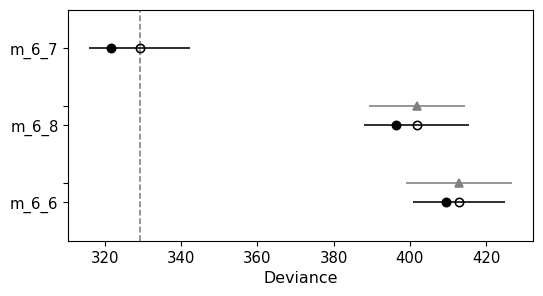

In [54]:
az.plot_compare(compare_df)

#### Code 7.30

In [60]:
waic_m_6_6 = az.waic(m_6_6_trace, pointwise=True, scale='deviance')
diff_m6_6_m6_8 = waic_m_6_6.waic_i - waic_m_6_8.waic_i
n = len(diff_m6_6_m6_8)
((n * diff_m6_6_m6_8.var())**0.5).values

array(8.72874456)